In [1]:
import sys
sys.path.append("../")

import os
import cv2
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
from augraphy import *
import albumentations as A
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from utils.plot_util import visualize_class_distribution, visualize_class_images

# 데이터 로드

In [2]:
data_path = "../dataset"
image_path = f"{data_path}/train"

train_df = pd.read_csv(f"{data_path}/train.csv")
meta_df = pd.read_csv(f"{data_path}/meta.csv")

In [3]:
display(train_df.shape)
display(train_df.head())

(1570, 2)

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16


In [4]:
display(meta_df.shape)
display(meta_df['class_name'].unique())

(17, 2)

array(['account_number',
       'application_for_payment_of_pregnancy_medical_expenses',
       'car_dashboard', 'confirmation_of_admission_and_discharge',
       'diagnosis', 'driver_lisence', 'medical_bill_receipts',
       'medical_outpatient_certificate', 'national_id_card', 'passport',
       'payment_confirmation', 'pharmaceutical_receipt', 'prescription',
       'resume', 'statement_of_opinion',
       'vehicle_registration_certificate', 'vehicle_registration_plate'],
      dtype=object)

In [5]:
## 시각화 함수
def visualize(image, result):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Before')

    plt.subplot(2, 2, 2)
    plt.imshow(result)
    plt.title('After')

    plt.subplot(2, 2, 3)
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='black', alpha=0.5)
    plt.title('Before')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 4)
    plt.hist(result.ravel(), bins=256, range=[0, 256], color='black', alpha=0.5)
    plt.title('After')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.show()

In [6]:
## 샘플파일 선택
# files = train_df['ID'].to_list()

# idx = random.randint(0, len(train_df)-1)
# sample = files[idx]
# file_path = f"{data_path}/train/{sample}"
# print(idx, file_path)


file_path = f"{data_path}/train/fe30845b79d1d42f.jpg"
image = cv2.imread(file_path)

# Albumentations

In [7]:
def train_transform(img_h, img_w, mean=0, std=0):
    transform = A.Compose([
        A.OneOf([
            A.Compose([
                A.LongestMaxSize(max_size=max(img_h, img_w), p=1),
                A.PadIfNeeded(min_height=img_h, min_width=img_w, border_mode=0, value=(255, 255, 255), p=1),
            ], p=0.25),

            A.ShiftScaleRotate(shift_limit_x=(-0.2, 0.2), 
                               shift_limit_y=(-0.2, 0.2), 
                               scale_limit=(-0.05, 0.05), 
                               rotate_limit=(-60, 60), 
                               interpolation=0, 
                               border_mode=0, 
                               value=(255, 255, 255),
                               rotate_method='largest_box',
                               p=0.25),

            A.ElasticTransform(alpha=1.0, 
                               sigma=50.0, 
                               interpolation=0, 
                               border_mode=0, 
                               value=(0, 0, 0), 
                               mask_value=None, 
                               approximate=False, 
                               same_dxdy=False,
                               p=0.25),

            A.OpticalDistortion(distort_limit=(-0.3, 0.3), 
                                shift_limit=(-0.05, 0.05), 
                                interpolation=0, 
                                border_mode=0, 
                                value=(255, 255, 255), 
                                mask_value=None,
                                p=0.25)
        ], p=1),

        A.OneOf([
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.Transpose(p=0.3)
        ], p=0.4),

        A.Defocus(radius=(3, 5), alias_blur=(0.1, 0.5), p=0.2),
        A.RandomSizedCrop(min_max_height=(img_h//4, img_h//2), 
                          min_max_width=(img_h//4, img_h//2), 
                          height=213, width=320,
                          w2h_ratio=1.08, 
                          interpolation=0,
                          p=0.3),

        # A.Compose([
        #     A.Resize(height=img_h, width=img_w, always_apply=True, p=1.0),
        #     A.Normalize(mean, std, p=1, always_apply=True), ## (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        #     ToTensorV2(p=1, always_apply=True),
        # ], p=1)
        
    ])

    return transform

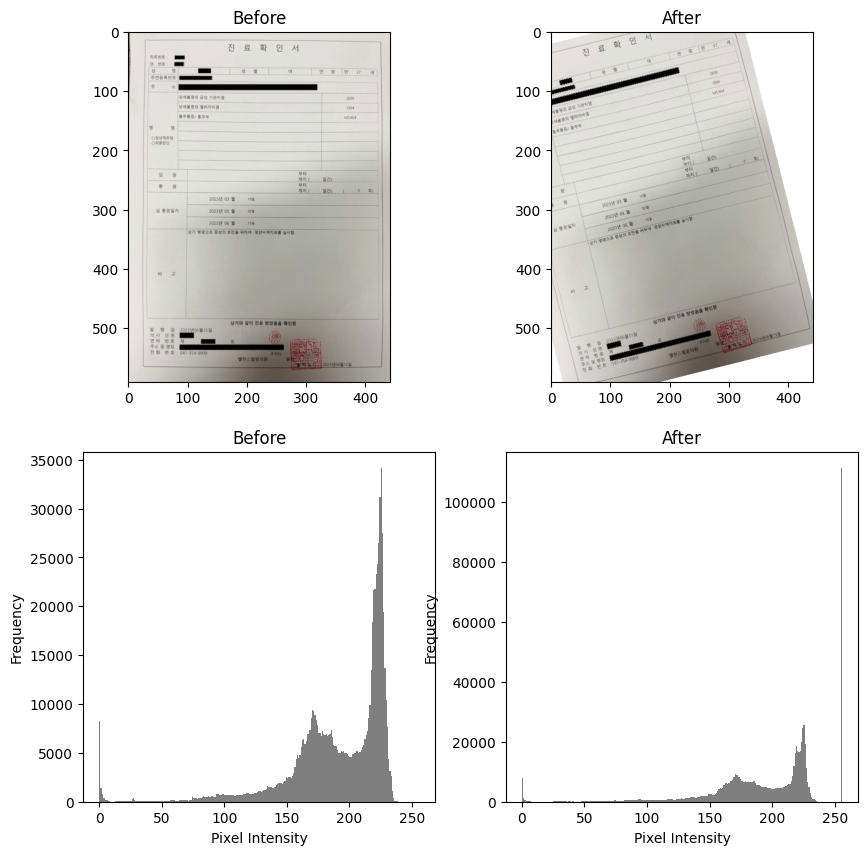

In [8]:
transform = train_transform(512, 512)
result = transform(image=image)['image']

visualize(image, result)

# Augraphy

In [9]:
def augraphy_transform(img_h, img_w):
    ink_phase = [
        ## 번짐효과. 글자를 진하게 만든다.
        InkBleed(
            intensity_range=(0.5, 0.6),
            kernel_size=random.choice([(5, 5), (3, 3)]),
            severity=(0.2, 0.4),
            p=0.5),

        ## augraphy_cache에 있는 이미지 중 랜덤으로 선택해 InkBleedThrough(mixup과 유사.)
        # BleedThrough(
        #     intensity_range=(0.1, 0.3),
        #     color_range=(32, 224),
        #     ksize=(17, 17),
        #     sigmaX=1,
        #     alpha=random.uniform(0.1, 0.2),
        #     offsets=(10, 20), p=0.8),

        # OneOf([
        #     DotMatrix(dot_matrix_shape="circle",
        #             dot_matrix_dot_width_range=(5, 5),
        #             dot_matrix_dot_height_range=(5, 5),
        #             dot_matrix_min_width_range=(1, 1),
        #             dot_matrix_max_width_range=(50, 50),
        #             dot_matrix_min_height_range=(1, 1),
        #             dot_matrix_max_height_range=(50, 50),
        #             dot_matrix_min_area_range=(10, 10),
        #             dot_matrix_max_area_range=(800, 800),
        #             dot_matrix_median_kernel_value_range = (29,29),
        #             dot_matrix_gaussian_kernel_value_range=(1, 1),
        #             dot_matrix_rotate_value_range=(0, 0),
        #             p=0.25),
        #     Hollow(hollow_median_kernel_value_range = (101, 101),
        #            hollow_min_width_range=(1, 1),
        #            hollow_max_width_range=(200, 200),
        #            hollow_min_height_range=(1, 1),
        #            hollow_max_height_range=(200, 200),
        #            hollow_min_area_range=(10, 10),
        #            hollow_max_area_range=(5000, 5000),
        #            hollow_dilation_kernel_size_range = (3, 3),
        #            p=0.25),

        # ], p=0.5),


    ]

    paper_phase = [
        ## 종이 색상 변경.
        ColorPaper( hue_range=(0, 255), saturation_range=(10, 40), p=0.2),
        
        # AugmentationSequence([
        OneOf([
            ## 테스트 데이터 노이즈와 유사한듯??
            NoiseTexturize(sigma_range=(5, 15),
                           turbulence_range=(3, 9),
                           texture_width_range=(50, 500),
                           texture_height_range=(50, 500),
                           p=0.3),
            BrightnessTexturize(texturize_range=(0.8, 0.99), deviation=0.02, p=0.3),
            SubtleNoise(subtle_range=50, p=0.3),
        ], p=0.6),
    ]

    post_phase = [
        ## 부분 밝기, 그림자
        OneOf([
            # ColorShift(color_shift_offset_x_range=(3, 5),
            #            color_shift_offset_y_range=(3, 5),
            #            color_shift_iterations=(2, 3),
            #            color_shift_brightness_range=(0.9, 1.1),
            #            color_shift_gaussian_kernel_range=(3, 3),
            #            p=0),

            LightingGradient(light_position=None,
                             direction=90,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             transparency=0.5,
                             p=0.25),

            LowLightNoise(num_photons_range=(50, 100), 
                          alpha_range=(0.7, 0.9), 
                          beta_range=(10, 30), 
                          gamma_range=(1.0 , 1.8),
                          p=0.25),

            ReflectedLight(reflected_light_smoothness = 0.8,
                           reflected_light_internal_radius_range=(0.0, 0.2),
                           reflected_light_external_radius_range=(0.1, 0.8),
                           reflected_light_minor_major_ratio_range = (0.9, 1.0),
                           reflected_light_color = (255,255,255),
                           reflected_light_internal_max_brightness_range=(0.9,1.0),
                           reflected_light_external_max_brightness_range=(0.9,0.9),
                           reflected_light_location = "random",
                           reflected_light_ellipse_angle_range = (0, 360),
                           reflected_light_gaussian_kernel_size_range = (5,310),
                           p=0.25),

            ShadowCast(shadow_side = "bottom",
                    shadow_vertices_range = (2, 3),
                    shadow_width_range=(0.5, 0.8),
                    shadow_height_range=(0.5, 0.8),
                    shadow_color = (0, 0, 0),
                    shadow_opacity_range=(0.5,0.6),
                    shadow_iterations_range = (1,2),
                    shadow_blur_kernel_range = (101, 301),
                    p=0.25)

        ], p=0.15),

        ## 무늬(패턴) 추가
        # OneOf([
        #     Moire(moire_density = (15,20),
        #           moire_blend_method = "normal",
        #           moire_blend_alpha = 0.1,
        #           p=0.5),

        #     PatternGenerator(imgx = 512,
        #                      imgy= 512,
        #                      n_rotation_range = (3, 7),
        #                      p=0.5)
        # ], p=0.15),

        # SectionShift(section_shift_number_range = (5,5),
        #             section_shift_locations = "random",
        #             section_shift_x_range = (20,20),
        #             section_shift_y_range = (20,20),
        #             section_shift_fill_value = (0, 0, 0),
        #             p=0.1),        

        # DoubleExposure(gaussian_kernel_range=(9,12), offset_direction=1, offset_range=(18,25), p=0.1),
    ]

    # rescale = Rescale(target_dpi=150)
    
    return AugraphyPipeline(
        # pre_phase=[rescale],
        ink_phase=ink_phase, 
        paper_phase=paper_phase, 
        post_phase=post_phase
    )

<class 'numpy.ndarray'> (591, 443, 3)


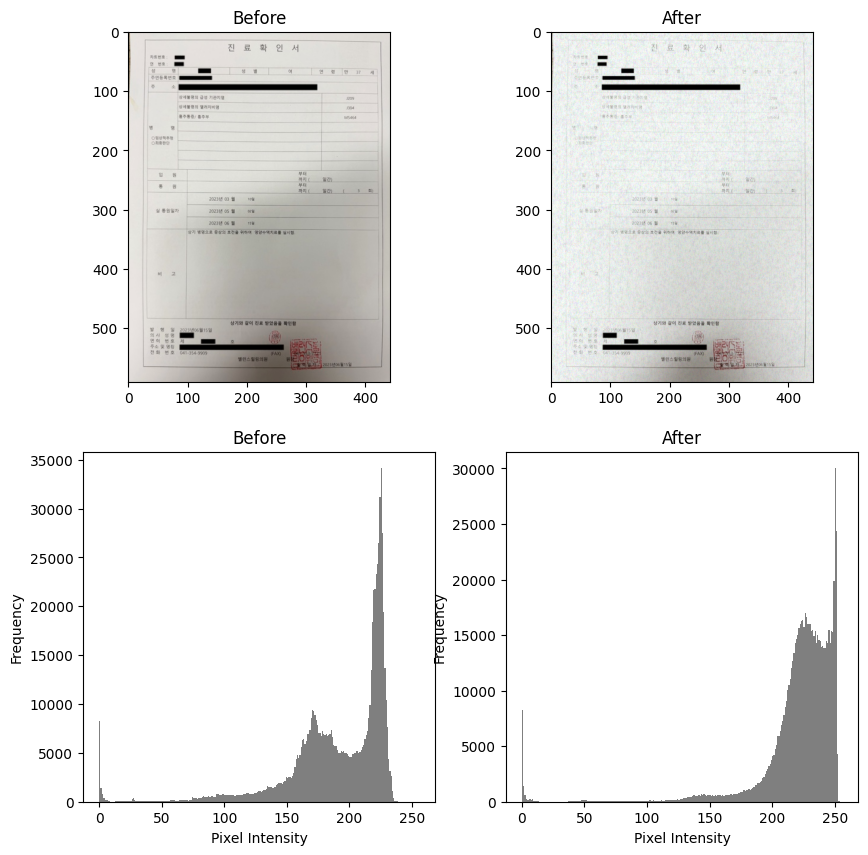

In [10]:
ap_transform = augraphy_transform(512, 512)
result = ap_transform(image)
print(type(result), result.shape)

visualize(image, result)

# Albumentations + Augraphy

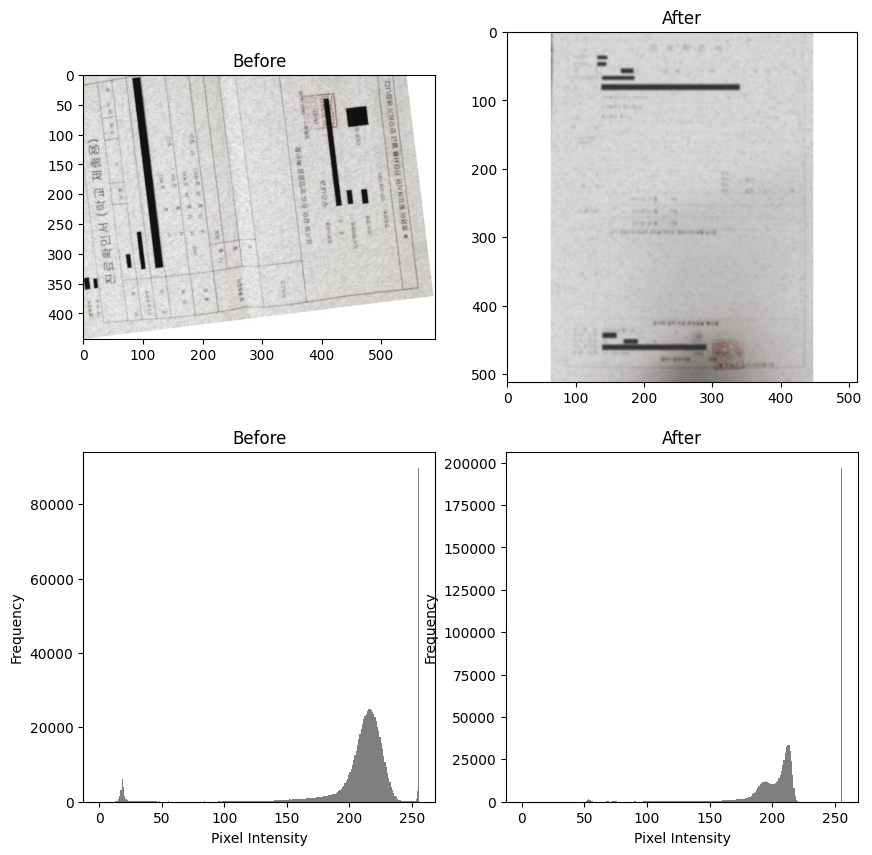

In [18]:
ap_img = ap_transform(image)
result = transform(image=ap_img)['image']

test_img = cv2.imread(f"{data_path}/test/0b0e7e754b5a103c.jpg")
visualize(test_img, result)